# Лабораторная работа 3. Цифровая обработка изображений.

В этой работе рассматриваются различные виды цифровой обработки изображений.

Цель лабораторной работы:
1. Метрики качества.
2. Фильтрация изображений
3. Линейная фильтрация изображений в пространственной области.
4. Линейная фильтрация изображений в частотной области

In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
import sys
#sys.path.append('../')
%matplotlib inline
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
#from utility import util

# Изменим стандартный размер графиков matplotlib
plt.rcParams["figure.figsize"] = [6, 4]

# 1. Метрики качества. Среднеквадратическая ошибка (MSE). Пиковое отношение сигнал/шум (PSNR).

Метрики качества служат для измерения схожести/различия между двумя изображениями.

## 1.1 PSNR
PSNR (peak signal-to-noise ratio, отношение пикового уровня сигнала к шуму) - наиболее часто используемая количественная метрика для измерения уровня искажений при работе с изображениями.

PSNR наиболее часто используется для измерения уровня искажений при сжатии изображений.

$$
PSNR = 10 \cdot log_{10}\frac{MAX^2_I}{MSE},
$$
где $MAX_I$ максимально возможное значение пикселя. Для 8-битного изображения - 255;
$$
MSE = \frac{1}{mn} \sum\limits_{i=0}^{m-1} \sum\limits_{j=0}^{n-1} |I(i,j) - K(i,j)|^2.
$$
Когда два изображения одинаковы, MSE даст ноль, что приведет к недопустимой операции деления на ноль в формуле PSNR. В этом случае PSNR не определен, и нам нужно будет рассматривать этот случай отдельно. Переход на логарифмическую шкалу происходит потому, что значения пикселей имеют очень широкий динамический диапазон. Готовая функция выглядит так:

In [ ]:
def getPSNR(I1, I2):
    s1 = cv.absdiff(I1, I2)  #|I1 - I2| - модуль разницы двух изображений
    s1 = np.float32(s1)
    s1 = s1 * s1  # |I1 - I2|^2
    sse = s1.sum()  # сумма элементов в каждом канале
    if sse <= 1e-10:  # сумма каналов
        return 0
    else:
        shape = I1.shape
        p=1
        for i in shape:
          p *= i
        mse = 1.0 * sse /p
        psnr = 10.0 * np.log10((255 * 255) / mse)
        return psnr

Обычно значения результатов составляют от 30 до 50 (дБ). Если изображения значительно отличаются, вы получите гораздо более низкие (15 и ниже).

Проблема PSNR в том, что на практике она может не совпадать с субъективной оценкой качества изображения (видео) человеком. Это может привести, например, к неверному выводу о превосходстве одного кодека над другим.

## 1.2 SSIM

SSIM (structure similarity, структурное сходство) точнее учитывает особенности восприятия изображения и видео человеком.

SSIM метрика рассчитана на различные размеры окна. Разница между двумя окнами ${\displaystyle x}$ и ${\displaystyle y}$ имеющими одинаковый размер N×N:

$$
{\text{SSIM}}(x,y)={\frac  {(2\mu _{x}\mu _{y}+c_{1})(2\sigma _{{xy}}+c_{2})}{(\mu _{x}^{2}+\mu _{y}^{2}+c_{1})(\sigma _{x}^{2}+\sigma _{y}^{2}+c_{2})}},
$$
где:
- $\mu _{x}$ — среднее x,
- $\mu _{y}$ — среднее y,
- $\sigma_{x}^{2}$ — дисперсия x,
- $\sigma_{y}^{2}$ — дисперсия y,
- $\sigma_{xy}$ — ковариация x и y,
- $c_{1}=(k_{1}L)^{2}, \; c_{2}=(k_{2}L)^{2}$ — две переменных:
    + L — динамический диапазон пикселей (обычно $2^\text{bits per pixel}-1)$,
    + $k_{1}$=0,01 и $k_{2}$=0,03 — константы.

Для 8 битного изображения:
- $c_{1} = (0,01 * 2^8 - 1)^2 = 6,5025;$
- $c_{2} = (0,03 * 2^8 - 1)^2 = 58,5225.$

SSIM вычисляется для каждого канала в отдельности.

In [ ]:
def getSSIM(i1, i2):
    C1 = 6.5025  # для 8-битного изоражения
    C2 = 58.5225  # для 8-битного изоражения
    # INITS
    I1 = np.float32(i1)
    I2 = np.float32(i2)
    I2_2 = I2 * I2  # I2^2
    I1_2 = I1 * I1  # I1^2
    I1_I2 = I1 * I2  # I1 * I2

    mu1 = cv.GaussianBlur(I1, (11, 11), 1.5)
    mu2 = cv.GaussianBlur(I2, (11, 11), 1.5)
    mu1_2 = mu1 * mu1
    mu2_2 = mu2 * mu2
    mu1_mu2 = mu1 * mu2
    sigma1_2 = cv.GaussianBlur(I1_2, (11, 11), 1.5)
    sigma1_2 -= mu1_2
    sigma2_2 = cv.GaussianBlur(I2_2, (11, 11), 1.5)
    sigma2_2 -= mu2_2
    sigma12 = cv.GaussianBlur(I1_I2, (11, 11), 1.5)
    sigma12 -= mu1_mu2
    t1 = 2 * mu1_mu2 + C1
    t2 = 2 * sigma12 + C2
    t3 = t1 * t2  # t3 = ((2*mu1_mu2 + C1).*(2*sigma12 + C2))
    t1 = mu1_2 + mu2_2 + C1
    t2 = sigma1_2 + sigma2_2 + C2
    t1 = t1 * t2  # t1 =((mu1_2 + mu2_2 + C1).*(sigma1_2 + sigma2_2 + C2))
    ssim_map = cv.divide(t3, t1)  # ssim_map =  t3./t1;
    ssim = cv.mean(ssim_map)  # mssim = average of ssim map
    ssim = ssim[:3]
    return ssim

Посчитаем PSNR и SSIM для изображений lenna.png и его ухудшенного варианта lenna_bad.png:

PSNR =  18.905294
SSIM =  (0.9067636675133599, 0.8454612847169756, 0.9498676286912087)


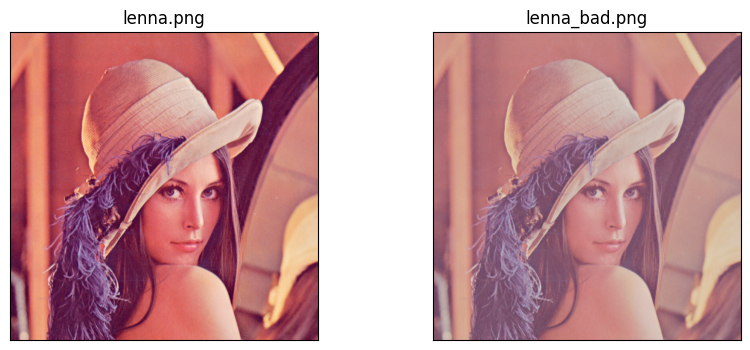

In [ ]:
image1 = cv.imread('./sample_data/lenna.png')
image2 = cv.imread('./sample_data/lenna_bad.png')
gray_image1 = cv.cvtColor(image1, cv.COLOR_BGR2GRAY)
gray_image2 = cv.cvtColor(image2, cv.COLOR_BGR2GRAY)
rgb_image1 = cv.cvtColor(image1, cv.COLOR_BGR2RGB)
rgb_image2 = cv.cvtColor(image2, cv.COLOR_BGR2RGB)

# rgb_image1 = cv.cvtColor(image1, cv.COLOR_BGR2RGB)

gs = plt.GridSpec(1, 2)
plt.figure(figsize=(10, 4))
plt.subplot(gs[0])
plt.imshow(rgb_image1)
plt.title('lenna.png')
plt.xticks([]), plt.yticks([])
plt.subplot(gs[1])
plt.imshow(rgb_image2)
plt.title('lenna_bad.png')
plt.xticks([]), plt.yticks([])

print('PSNR = ', getPSNR(image1, image2))
print('SSIM = ', getSSIM(image1, image2))

# 2. Фильтрация изображений.

## 2.1 Задача фильтрации изображений. Модели шумов.
Под задачей "фильтрации изображений" в широком смысле понимают любые процедуры обработки изображений, при которых на вход процедуры подается (одно) растровое изображение, и на выходе также формируется растровое изображение. Такие процедуры типа (один растровый вход, один растровый выход) называют *фильтрами*.

Однако чаще под "фильтрацией" в более узком смысле понимают так называемую *помеховую фильтрацию*, или фильтрацию изображений от "шума". Задача помеховой фильтрации, сводится к тому, чтобы путем некоторой обработки наблюдаемого реального изображения как можно лучше "очистить его от шума", то есть получить изображение, наиболее близкое по своим характеристикам к исходному "незашумленному" изображению.

Для изучения методов фильтрации мы будем изображения зашумлять. Для этого будем использовать разные модели шумов:
- модель "соль и перец", под которым понимают замещение значения пикселя на 0 с вероятностью p и -- на 1 с вероятностью q

- модель аддитивного гауссовского шума, который описывается простой формулой:
$ Im^{\prime}[x,y] = Im[x,y] + N[0,\sigma] $,
где $N(\mu, \sigma)$ - нормальное распределение, $\mu$ - математическое ожидание, а $\sigma$ - среднеквадратическое отклонение.


Для дальнейшего выполнения работы нам понадобятся функции наложения шума на изображение.
Функция add_gauss_noise добавляет гауссовский шум, функция add_salt_and_peper_noise добавляет импульсные помехи.

In [ ]:
def add_gauss_noise(image, mean, sigma):
    image = np.array(image / 255, dtype=float)
    noise = np.random.normal(mean, sigma, image.shape)
    noisy_image = image + noise
    out = np.clip(noisy_image, 0, 1.0)
    out = np.uint8(out * 255)
    return out


def add_salt_and_peper_noise(im, fraction=0.01):
    assert (0 < fraction <= 1.), "Fraction must be in (0, 1]"

    if len(im.shape) == 3:
      sp = np.zeros(im.shape)
      percent = round(fraction * 100 / 2.)

      cv.randu(sp, 0, 100)
      sp[:,:,1] = sp[:,:,0]
      sp[:,:,2] = sp[:,:,0]

      im_sp = im.copy()
      im_sp[sp < percent] = 0
      im_sp[sp > 100 - percent] = 255
      return im_sp

    if len(im.shape) == 2:
      sp = np.zeros(im.shape)
      percent = round(fraction * 100 / 2.)

      cv.randu(sp, 0, 100)

      im_sp = im.copy()
      im_sp[sp < percent] = 0
      im_sp[sp > 100 - percent] = 255
      return im_sp

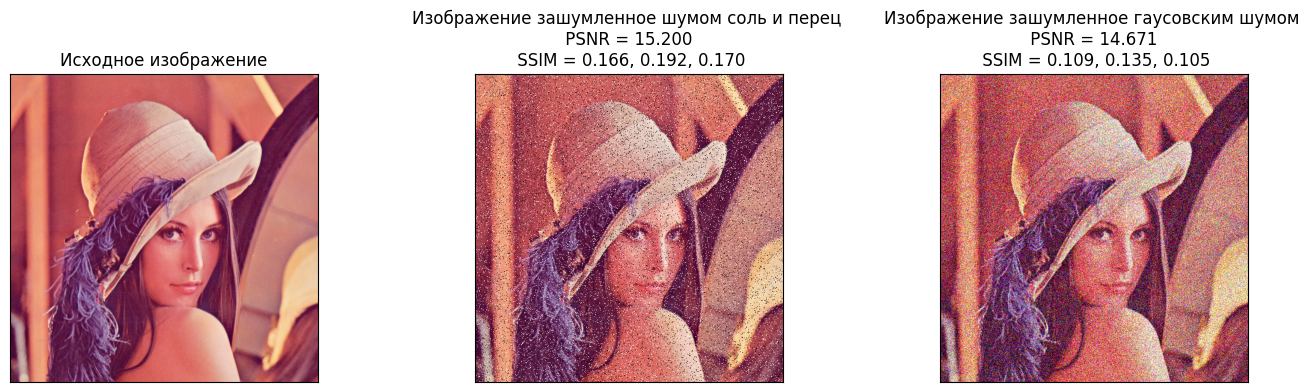

In [ ]:
gs = plt.GridSpec(1, 3)
plt.figure(figsize=(17, 4))

plt.subplot(gs[0])
plt.title('Исходное изображение')
plt.xticks([]), plt.yticks([])
plt.imshow(rgb_image1)

plt.subplot(gs[1])
plt.xticks([]), plt.yticks([])
noisy_image = add_salt_and_peper_noise(rgb_image1, 0.1)
psnr = getPSNR(rgb_image1, noisy_image)
ssim = getSSIM(rgb_image1, noisy_image)
plt.title(f'Изображение зашумленное шумом соль и перец \n PSNR = {psnr:.3f} \n SSIM = {ssim[0]:.3f}, {ssim[1]:.3f}, {ssim[2]:.3f}')
plt.imshow(noisy_image)

plt.subplot(gs[2])
plt.xticks([]), plt.yticks([])
noisy_image = add_gauss_noise(rgb_image1, 0, 0.2)
psnr = getPSNR(rgb_image1, noisy_image)
ssim = getSSIM(rgb_image1, noisy_image)
plt.title(f'Изображение зашумленное гаусовским шумом \n PSNR = {psnr:.3f} \n SSIM = {ssim[0]:.3f}, {ssim[1]:.3f}, {ssim[2]:.3f}')
plt.imshow(noisy_image, 'gray')
plt.show()

## 2.2 Нелинейная фильтрация полутоновых изображений

Значения отсчётов внутри окна фильтра сортируются в порядке возрастания (убывания); и значение, находящееся в середине упорядоченного списка, поступает на выход фильтра. В случае чётного числа отсчётов в окне выходное значение фильтра равно среднему значению двух отсчётов в середине упорядоченного списка. Окно перемещается вдоль фильтруемого сигнала, и вычисления повторяются.

Медианная фильтрация — эффективная процедура обработки сигналов, подверженных воздействию импульсных помех.


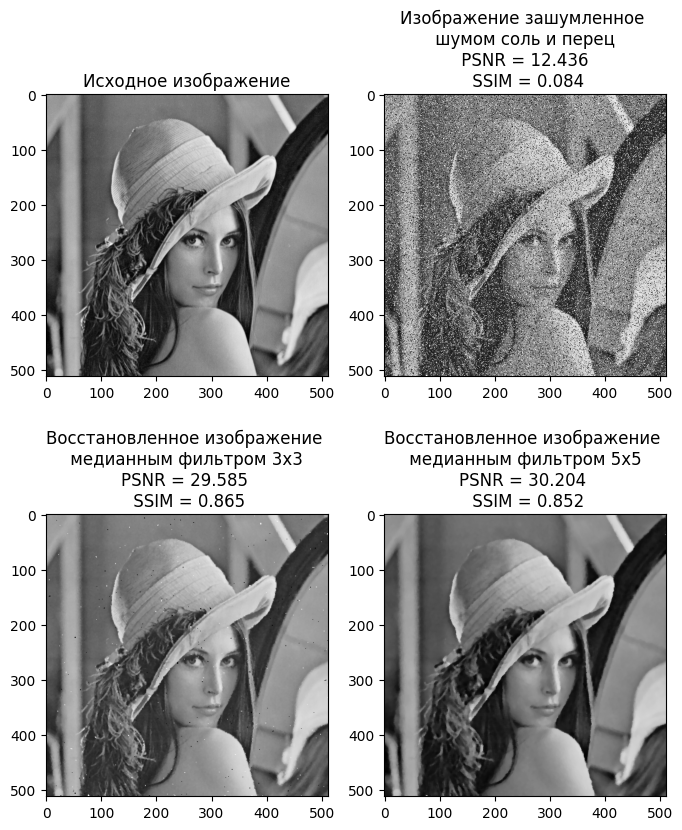

In [ ]:
image1 = cv.imread('./sample_data/lenna.png')
gray_image1 = cv.cvtColor(image1, cv.COLOR_BGR2GRAY)

sap_image1 = add_salt_and_peper_noise(gray_image1, 0.2)
median_image1 = cv.medianBlur(sap_image1, 3)
median_image2 = cv.medianBlur(sap_image1, 5)

gs = plt.GridSpec(2, 2)
plt.figure(figsize=(8, 10))
plt.subplot(gs[0])
plt.imshow(gray_image1, cmap='gray')
plt.title('Исходное изображение')

plt.subplot(gs[1])
plt.imshow(sap_image1, cmap='gray')
psnr = getPSNR(gray_image1, sap_image1)
ssim = getSSIM(gray_image1, sap_image1)

plt.title(f'Изображение зашумленное \n шумом соль и перец \n PSNR = {psnr:.3f} \n SSIM = {ssim[0]:.3f}')

plt.subplot(gs[2])
plt.imshow(median_image1, cmap='gray')
psnr = getPSNR(gray_image1, median_image1)
ssim = getSSIM(gray_image1, median_image1)
plt.title(f'Восстановленное изображение \n '
          f'медианным фильтром 3х3 \n'
          f'PSNR = {psnr:.3f} \n SSIM = {ssim[0]:.3f}')

plt.subplot(gs[3])
plt.imshow(median_image2, cmap='gray')
psnr = getPSNR(gray_image1, median_image2)
ssim = getSSIM(gray_image1, median_image2)
plt.title(f'Восстановленное изображение \n '
          f'медианным фильтром 5х5 \n'
          f'PSNR = {psnr:.3f} \n SSIM = {ssim[0]:.3f}')

plt.show()

Как видно из примера, медианная фильтрация является крайне эффективным методом фильтрации шумов.

# 3. Линейная фильтрация изображений в пространственной области.

Вся линейная фильтрация выражается через операцию свертки изображения с ядром фильтра. Выражение свертки записывается следующей формулой:

$$
g(x,y) = \omega \ast f(x,y) = \sum\limits_{dx=-a}^a \sum\limits_{dy=-b}^b \omega(dx,dy)f(x+dx,y+dy)
$$

где:
- $g(x,y)$ - отфильтрованное изображение;
- $f(x,y)$ - исходное изображение;
- $\omega$ - ядро фильтра.

Ядро фильтра представляет собой матрицу значений, которые определяют операцию над изображением.

## 3.1 Сглаживание изображения

**Скользящее среднее.**

Простейшим видом линейной фильтрации в пространственной области является скользящее среднее. Результатом фильтрации является математические ожидания, вычисленные по всем пикселям окна. Математически это эквивалентно свертке с ядром, все элемены которого равны 1/n, где n - количество элементов матрицы. Например, ядро 3х3 имеет следующий вид:

$$
\frac{1}{9}
 \begin{pmatrix}
  1 & 1 & 1 \\
  1 & 1 & 1 \\
  1 & 1 & 1
 \end{pmatrix}
$$

OpenCV предоставляет функцию cv.filter2D() для свертки ядра с изображением.

**Гауссиан.**


Повысить устойчивость результатов фильтрации на краях областей можно, если придать более близким точкам окрестности большее влияние на окончательный результат, чем дальним. Примером реализации этой идеи для окна размера 3×3 является маска:

$$
\frac{1}{16}
 \begin{pmatrix}
  1 & 2 & 1 \\
  2 & 4 & 2 \\
  1 & 2 & 1
 \end{pmatrix}
$$

Такая маска называется гауссовой. Соответственно, и использующий ее линейный фильтр также называется гауссовым. Используя дискретные приближения двумерной гауссовой функции, можно получить и другие гауссовы ядра большего размера. Обратите внимание на то, что сглаживающие или фильтрующие маски линейных фильтров должны иметь сумму всех элементов, равную 1.

OpenCV предоставляет функцию cv.filter2D() для свертки ядра с изображением.


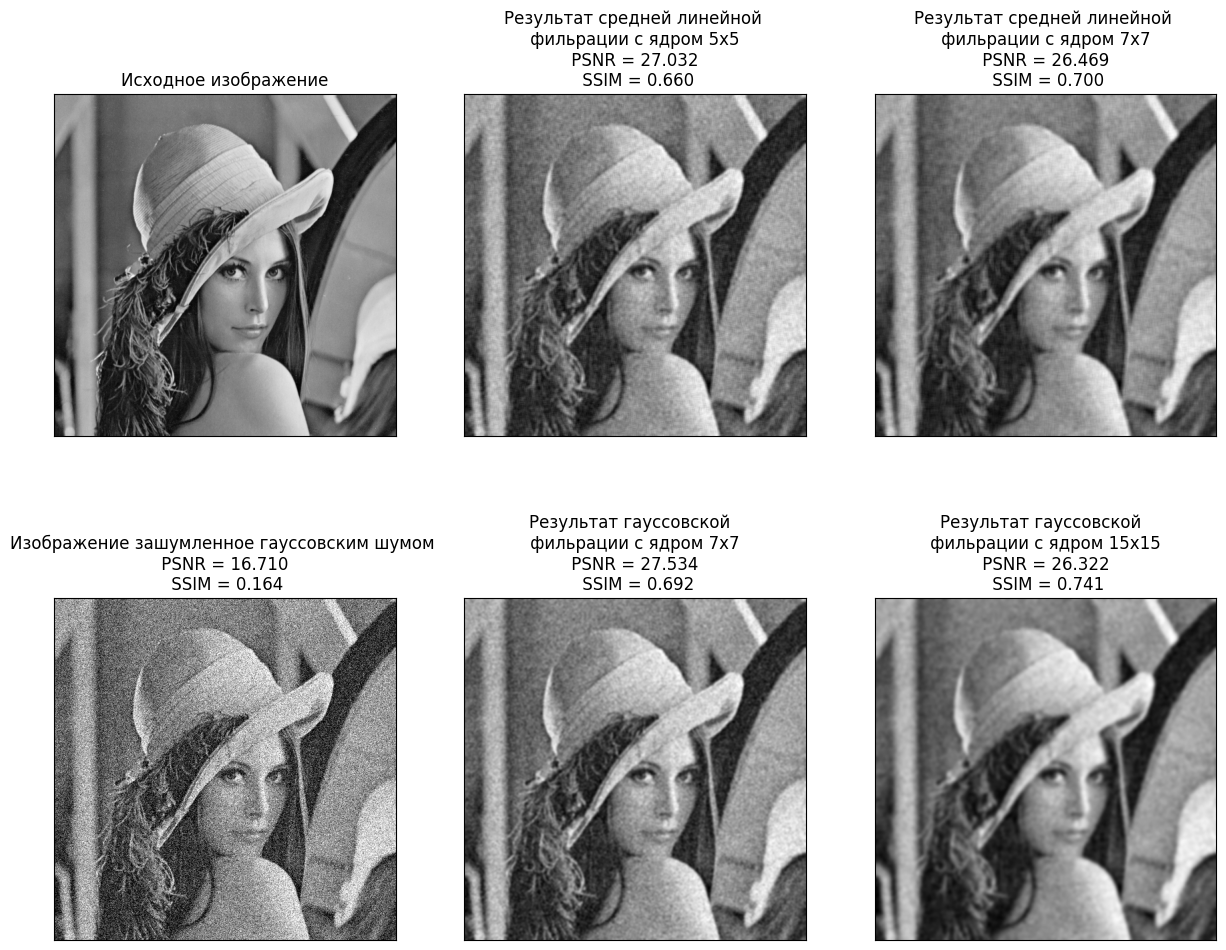

In [ ]:
kernel55 = np.ones((5, 5), np.float32) / 25
kernel77 = np.ones((7, 7), np.float32) / 49

noisy_image = add_gauss_noise(gray_image1, 0, 0.15)

filtered_image1 = cv.filter2D(noisy_image, -1, kernel55)
filtered_image2 = cv.filter2D(noisy_image, -1, kernel77)
gaussian_image1 = cv.GaussianBlur(noisy_image, (7, 7), 0)
gaussian_image2 = cv.GaussianBlur(noisy_image, (15, 15), 0)

# вывод
gs = plt.GridSpec(2, 3)
plt.figure(figsize=(15, 12))

plt.subplot(gs[0, 0])
plt.xticks([]), plt.yticks([])
plt.title('Исходное изображение')
plt.imshow(gray_image1, cmap='gray')

plt.subplot(gs[1, 0])
plt.xticks([]), plt.yticks([])
plt.imshow(noisy_image, cmap='gray')
psnr = getPSNR(gray_image1, noisy_image)
ssim = getSSIM(gray_image1, noisy_image)
plt.title(f'Изображение зашумленное гауссовским шумом \n PSNR = {psnr:.3f} \n SSIM = {ssim[0]:.3f}')

plt.subplot(gs[0, 1])
plt.xticks([]), plt.yticks([])
plt.title(f'Результат средней линейной \n фильрации с ядром 5х5 \n '
          f'PSNR = {getPSNR(gray_image1, filtered_image1):.3f} \n '
          f'SSIM = {getSSIM(gray_image1, filtered_image1)[0]:.3f}')
plt.imshow(filtered_image1, 'gray')

plt.subplot(gs[0, 2])
plt.xticks([]), plt.yticks([])
plt.title(f'Результат средней линейной \n фильрации с ядром 7х7 \n '
          f'PSNR = {getPSNR(gray_image1, filtered_image2):.3f} \n '
          f'SSIM = {getSSIM(gray_image1, filtered_image2)[0]:.3f}')
plt.imshow(filtered_image2, 'gray')

plt.subplot(gs[1, 1])
plt.xticks([]), plt.yticks([])
plt.title(f'Результат гауссовской  \n фильрации с ядром 7х7 \n '
          f'PSNR = {getPSNR(gray_image1, gaussian_image1):.3f} \n '
          f'SSIM = {getSSIM(gray_image1, gaussian_image1)[0]:.3f}')
plt.imshow(gaussian_image1, 'gray')

plt.subplot(gs[1, 2])
plt.xticks([]), plt.yticks([])
plt.title(f'Результат гауссовской  \n фильрации с ядром 15х15 \n '
          f'PSNR = {getPSNR(gray_image1, gaussian_image2):.3f} \n '
          f'SSIM = {getSSIM(gray_image1, gaussian_image2)[0]:.3f}')
plt.imshow(gaussian_image2, 'gray')

plt.show()

Как видно по изображениям линейные фильтры хоть и позволяют несколько отфильтровывать шумы за счет сглаживания, при этом размывая изображение, однако они не столь эффективны против импульсных шумов по сравнению с нелинейными ранговыми фильтрами.


## 3.2 Повышение резкости изображения

Повысить резкость изображения можно если свернуть его со следующими ядрами (у них нет специальных названий, поэтому просто пронумеруем их):
Ядро 1:
$
 \begin{pmatrix}
  -1 & -1 & -1 \\
  -1 & 9 & -1 \\
  -1 & -1 & -1
 \end{pmatrix}
$

Ядро 2:
$
 \begin{pmatrix}
  -0.25 & -0.25 & -0.25 \\
  -0.25 & 3 & -0.25 \\
  -0.25 & -0.25 & -0.25
 \end{pmatrix}
$

Ядро 3:
$
 \begin{pmatrix}
  0 & -0.25 & 0 \\
  -0.25 & 2 & -0.25 \\
  0 & -0.25 & 0
 \end{pmatrix}
$


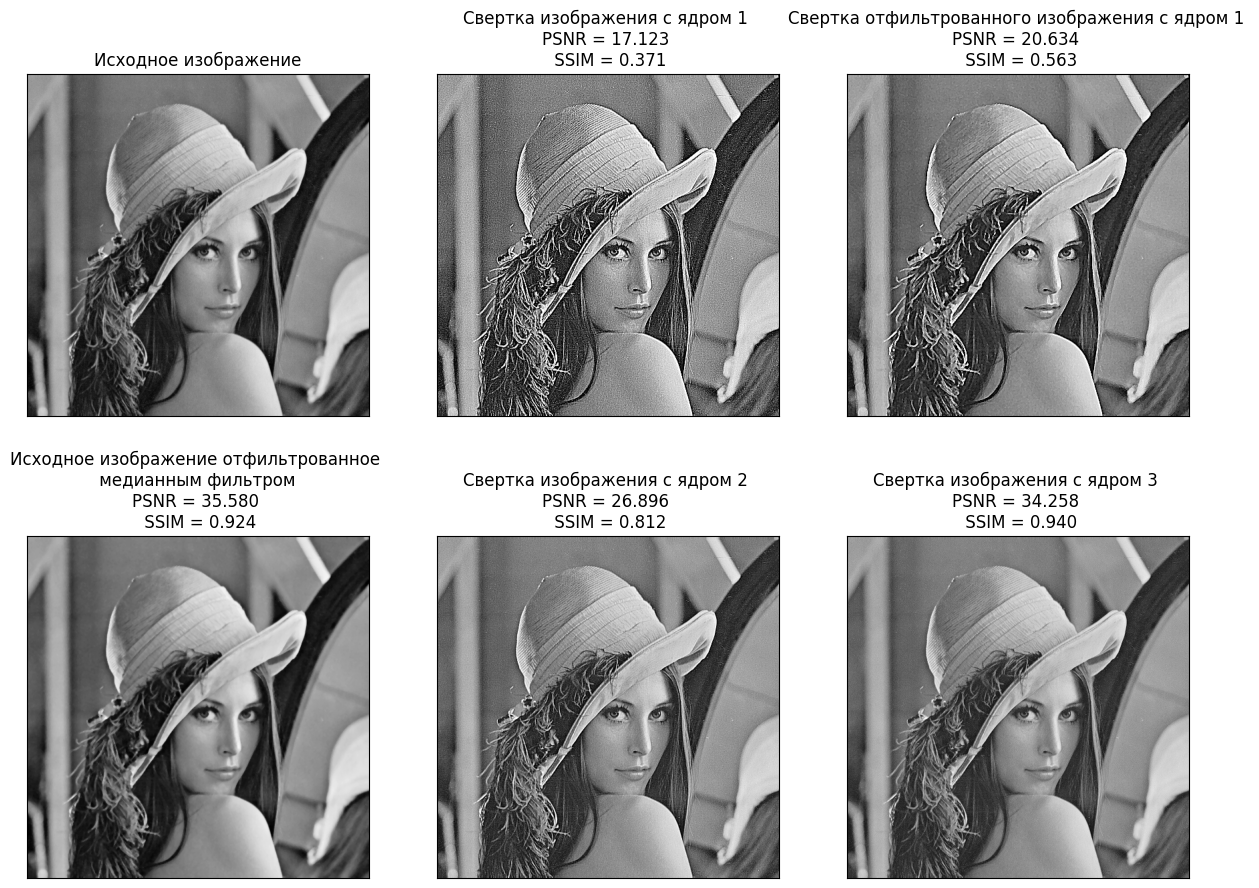

In [ ]:
kernel1 = np.asarray([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
kernel2 = np.asarray([[-0.25, -0.25, -0.25], [-0.25, 3, -0.25], [-0.25, -0.25, -0.25]])
kernel3 = np.asarray([[0, -0.25, 0], [-0.25, 2, -0.25], [0, -0.25, 0]])

gray_image1_median = cv.medianBlur(gray_image1, 3)

filtered_image1 = cv.filter2D(gray_image1, -1, kernel1)
filtered_image1_median = cv.filter2D(gray_image1_median, -1, kernel1)
filtered_image2 = cv.filter2D(gray_image1, -1, kernel2)
filtered_image2_median = cv.filter2D(gray_image1_median, -1, kernel2)
filtered_image3 = cv.filter2D(gray_image1, -1, kernel3)
filtered_image3_median = cv.filter2D(gray_image1_median, -1, kernel3)

# вывод
plt.figure(figsize=(15, 17))

plt.subplot(331)
plt.xticks([]), plt.yticks([])
plt.title('Исходное изображение')
plt.imshow(gray_image1, cmap='gray')

plt.subplot(334)
plt.xticks([]), plt.yticks([])
plt.title(f'Исходное изображение отфильтрованное \n медианным фильтром \n'
          f'PSNR = {getPSNR(gray_image1, gray_image1_median):.3f} \n '
          f'SSIM = {getSSIM(gray_image1, gray_image1_median)[0]:.3f}')
plt.imshow(gray_image1_median, cmap='gray')

plt.subplot(332)
plt.xticks([]), plt.yticks([])
plt.title(f'Свертка изображения с ядром 1 \n'
          f'PSNR = {getPSNR(gray_image1, filtered_image1):.3f} \n '
          f'SSIM = {getSSIM(gray_image1, filtered_image1)[0]:.3f}')
plt.imshow(filtered_image1, 'gray')

plt.subplot(333)
plt.xticks([]), plt.yticks([])
plt.title(f'Свертка отфильтрованного изображения с ядром 1 \n'
          f'PSNR = {getPSNR(gray_image1, filtered_image1_median):.3f} \n '
          f'SSIM = {getSSIM(gray_image1, filtered_image1_median)[0]:.3f}')
plt.imshow(filtered_image1_median, 'gray')

plt.subplot(335)
plt.xticks([]), plt.yticks([])
plt.title(f'Свертка изображения с ядром 2 \n'
          f'PSNR = {getPSNR(gray_image1, filtered_image2):.3f} \n '
          f'SSIM = {getSSIM(gray_image1, filtered_image2)[0]:.3f}')
plt.imshow(filtered_image2, 'gray')

plt.subplot(336)
plt.xticks([]), plt.yticks([])
plt.title(f'Свертка изображения с ядром 3 \n'
          f'PSNR = {getPSNR(gray_image1, filtered_image3):.3f} \n '
          f'SSIM = {getSSIM(gray_image1, filtered_image3)[0]:.3f}')
plt.imshow(filtered_image3, 'gray')

plt.show()

Применение фильтров повышающих резкость усиливают также и шумы. Это хорошо видно, если приблизить второе изображение ("Свертка изображения с ядром 1"). Улучшить ситуацию можно, если предварительно к исходному изображению применить медианный фильтр.
В разделе 2 говорилось о том, что существующие метрики качества на практике могут не совпадать с субъективной оценкой качества изображения (видео) человеком. Попробуйте выбрать изображение, которое вам кажется лучшим из представленных выше и оцените значения метрик качества. Сделайте выводы.

# 4. Линейная фильтрация изображений в частотной области.

Линейная фильтрация изображений может осуществляться как в пространственной, так и в частотной области. При этом считается, что нижним пространственным частотам соответствует основное содержание изображения - фон и крупноразмерные объекты, а верхним пространственным частотам - мелкоразмерные объекты, мелкие детали крупных форм и шумовая компонента.

Традиционно для перехода в область пространственных частот используются методы, основанные на преобразовании Фурье. В последние годы все большее применение находят также методы, основанные на вейвлет-преобразовании (wavelet-transform).

## 4.1 Преобразование Фурье

Поскольку изображение представляет собой дискретный сигнал, то к нему применяется дискретное преобразование Фурье (ДПФ).

ДПФ раскладывает сигнал на синусоидальные составляющие (которые называются гармониками) с частотами от 1 колебания за период до $N-1$ колебаний за период (плюс константа). Под периодом здесь понимается ширина и высота изображения в пикселях.
Особенности ДПФ таковы, то высокочастотные составляющие не могут быть корректно отображены — возникает муаровый эффект. Это приводит к тому, что вторая половина комплексных амплитуд, фактически, является зеркальным отображением первой и не несёт дополнительной информации. У ДПФ изображения зеркальными являются комплексные амплитуды в четырех квадрантах спектра.

Выполнить преобразование Фурье можно как с применением NumPy, так и OpenCV.

### Преобразование Фурье в NumPy

Для выполнения преобразования Фурье в NumPy существует пакет fft.

функция np.fft.fft2() выполняет преобразование Фурье, которое будет представлять собой сложный массив. Функия fft2() принимает несколько аргументов. Первым аргументом является входное изображение в оттенкаях серого. Второй аргумент является необязательным и определяет размер выходного массива. Если он больше размера входного изображения, входное изображение перед расчетом БПФ заполняется нулями. Если он меньше входного изображения, входное изображение будет обрезано. Если аргументы не переданы, размер выходного массива будет таким же, как и размер входного.

В результате, нулевой частотный компонент (постоянная составляющая) будет в левом верхнем углу. Если есть необходимость сместить его в центр (будет легче анализировать результат), то это можно сделать функцией np.fft.fftshift().


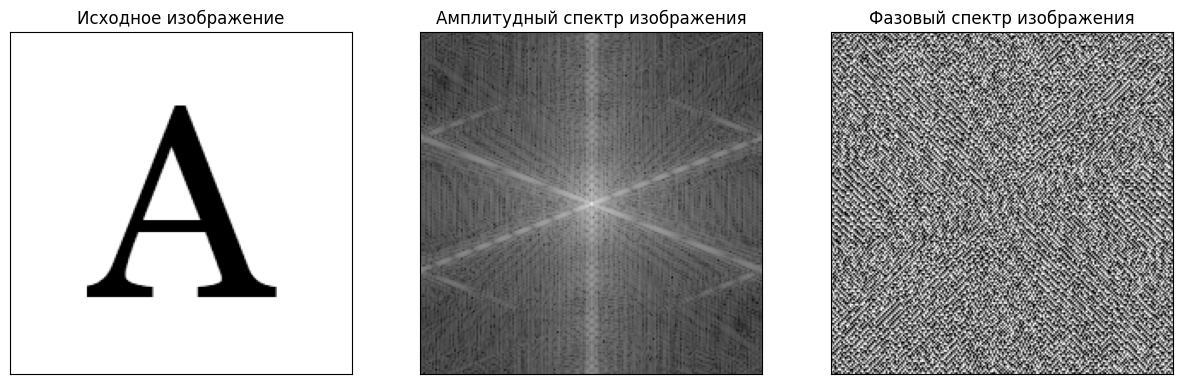

In [ ]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

img = cv.imread('./sample_data/A_letter.png')
gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
f = np.fft.fft2(gray_img)
fshift = np.complex64(np.fft.fftshift(f))
magnitude_spectrum = 20 * np.log(np.abs(fshift))
phase_spectrum = np.uint8(255 * (np.angle(fshift) + np.pi) / (2 * np.pi))

# вывод
plt.figure(figsize=(15, 12))
plt.subplot(131), plt.imshow(gray_img, cmap='gray')
plt.title('Исходное изображение'), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Амплитудный спектр изображения'), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(phase_spectrum, cmap='gray')
plt.title('Фазовый спектр изображения'), plt.xticks([]), plt.yticks([])
plt.show()

### Преобразование Фурье в OpenCV

В OpenCV также есть функции для прямого и обратного дискретного преобразования Фурье cv.dft() и cv.idft(), соответственно. Он возвращает тот же результат, что и предыдущий, но с двумя каналами. Первый канал будет иметь реальную часть результата, а второй канал будет иметь мнимую часть результата. Входное изображение должно быть сначала преобразовано в np.float32.

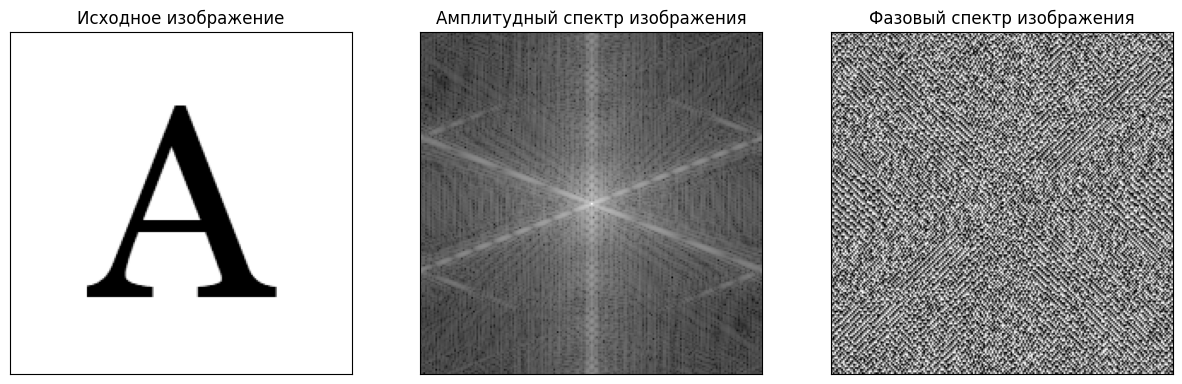

In [ ]:
dft = cv.dft(np.float32(gray_img), flags=cv.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)
magnitude_spectrum = 20 * np.log(cv.magnitude(dft_shift[..., 0], dft_shift[..., 1]))
phase_spectrum = cv.phase(dft_shift[..., 1], dft_shift[..., 0])
# вывод
plt.figure(figsize=(15, 15))
plt.subplot(131), plt.imshow(gray_img, cmap='gray')
plt.title('Исходное изображение'), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Амплитудный спектр изображения'), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(phase_spectrum, cmap='gray')
plt.title('Фазовый спектр изображения'), plt.xticks([]), plt.yticks([])
plt.show()

## 4.2 Фильтрация изображений в частотной области

Линейные методы фильтрации относятся к числу хорошо структурированных методов, для которых разработаны эффективные вычислительные схемы, основанные на быстрых алгоритмах свертки и спектральном анализе.

Наиболее эффективно линейные методы обработки реализуются в частотной области.

Использование Фурье-образа изображения для выполнения операций фильтрации обусловлено прежде всего более высокой производительностью таких операций. Как правило, выполнение прямого и обратного двумерного преобразования Фурье и умножение на коэффициенты Фурье-образа фильтра занимает меньше времени, чем выполнение двумерной свертки исходного изображения.

### Низкочастотная фильтрация
В качестве примера удалим высокочастотную составляющую изображения. Это фактически размывает изображение. Для этого мы используем маску с высоким значением (1) на низких частотах, т.е. пропускаем НЧ-контент, и 0 в ВЧ-области.

/tmp/ipython-input-1159775494.py:20: RuntimeWarning: divide by zero encountered in log
  magnitude_dft_shift_masked = 20 * np.log(


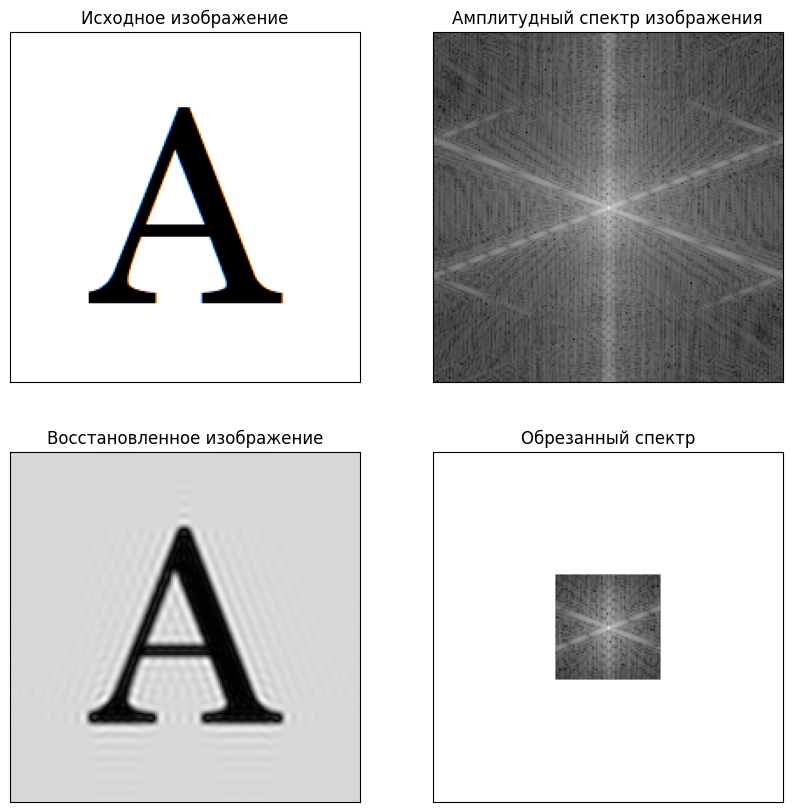

In [ ]:
r = 30
rows, cols = gray_img.shape
crow, ccol = np.uint32((rows / 2, cols / 2))
# create a mask first, center square is 1, remaining all zeros
mask = np.zeros((rows, cols, 2), np.uint8)
mask[crow - r:crow + r, ccol - r:ccol + r] = 1

# вычисляем фурье-образ
dft = cv.dft(np.float32(gray_img), flags=cv.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

# применяем маску и делаем обратное преобразование Фурье
dft_shift_masked = dft_shift * mask
f_ishift = np.fft.ifftshift(dft_shift_masked)
img_back = cv.idft(f_ishift)
img_back = cv.magnitude(img_back[..., 0], img_back[..., 1])

magnitude_dft_shift = 20 * np.log(
    cv.magnitude(dft_shift[..., 0], dft_shift[..., 1]))
magnitude_dft_shift_masked = 20 * np.log(
    cv.magnitude(dft_shift_masked[..., 0], dft_shift_masked[..., 1]))

# вывод
plt.figure(figsize=(10, 10))
plt.subplot(221), plt.imshow(img, cmap='gray')
plt.title('Исходное изображение'), plt.xticks([]), plt.yticks([])
plt.subplot(222), plt.imshow(magnitude_dft_shift, cmap='gray')
plt.title('Амплитудный спектр изображения'), plt.xticks([]), plt.yticks([])
plt.subplot(223), plt.imshow(img_back, cmap='gray')
plt.title('Восстановленное изображение'), plt.xticks([]), plt.yticks([])
plt.subplot(224), plt.imshow(magnitude_dft_shift_masked, cmap='gray')
plt.title('Обрезанный спектр'), plt.xticks([]), plt.yticks([])
plt.show()

Из примера видно, что устранив высокочастотную часть фурье-образа и восстановив обратно изображение, мы выполнили низкочастотную фильтрацию. Границы восстановленного изображения стали размытыми.
Попробуйте поменять в большую и меньшую сторону значение r, формирующее размер маски и посмотрите, как оно влияет на восстановленное изображение.

### Задание: попробуйте выполнить низкочастотную фильтрацию в частотной области зашумленного изображения, как это сделано в разделе 3.1. Сделайте выводы.

### Высокочастотная фильтрация
Таким же способом можно осуществить высокочастотную фильтрацию. Для этого нужно обнулить низкочастотную составляющую Фурье-образа.

/tmp/ipython-input-1646394789.py:20: RuntimeWarning: divide by zero encountered in log
  magnitude_dft_shift_masked = 20 * np.log(


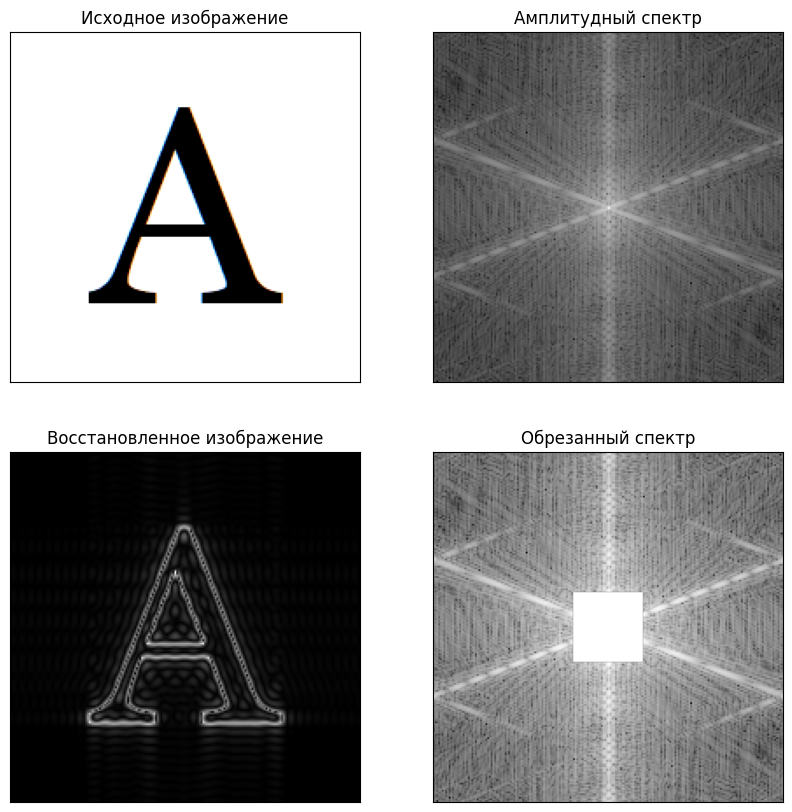

In [ ]:
r = 20
rows, cols = gray_img.shape
crow, ccol = np.uint32((rows / 2, cols / 2))
# create a mask first, center square is 1, remaining all zeros
mask = np.ones((rows, cols, 2), np.uint8)
mask[crow - r:crow + r, ccol - r:ccol + r] = 0

# вычисляем фурье-образ
dft = cv.dft(np.float32(gray_img), flags=cv.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

# применяем маску и делаем обратное преобразование Фурье
dft_shift_masked = dft_shift * mask
f_ishift = np.fft.ifftshift(dft_shift_masked)
img_back = cv.idft(f_ishift)
img_back = cv.magnitude(img_back[..., 0], img_back[..., 1])

magnitude_dft_shift = 20 * np.log(
    cv.magnitude(dft_shift[..., 0], dft_shift[..., 1]))
magnitude_dft_shift_masked = 20 * np.log(
    cv.magnitude(dft_shift_masked[..., 0], dft_shift_masked[..., 1]))

# вывод
plt.figure(figsize=(10, 10))
plt.subplot(221), plt.imshow(img, cmap='gray')
plt.title('Исходное изображение'), plt.xticks([]), plt.yticks([])
plt.subplot(222), plt.imshow(magnitude_dft_shift, cmap='gray')
plt.title('Амплитудный спектр'), plt.xticks([]), plt.yticks([])
plt.subplot(223), plt.imshow(img_back, cmap='gray')
plt.title('Восстановленное изображение'), plt.xticks([]), plt.yticks([])
plt.subplot(224), plt.imshow(magnitude_dft_shift_masked, cmap='gray')
plt.title('Обрезанный спектр'), plt.xticks([]), plt.yticks([])
plt.show()


Из примера видно, что устранив низкочастотную часть фурье-образа и восстановив обратно изображение, мы выполнили высокочастотную фильтрацию. На изображении остались пиксели в окрестности которых произошло значительное изменение яркости. Как правило, значительное изменение яркости происходит на границах объектов, что мы и видим на примере выше. Высокочастотная фильтрация является одним из способов задачи выделения контуров на изображениях, которую рассмотрим позже.

 Задание:

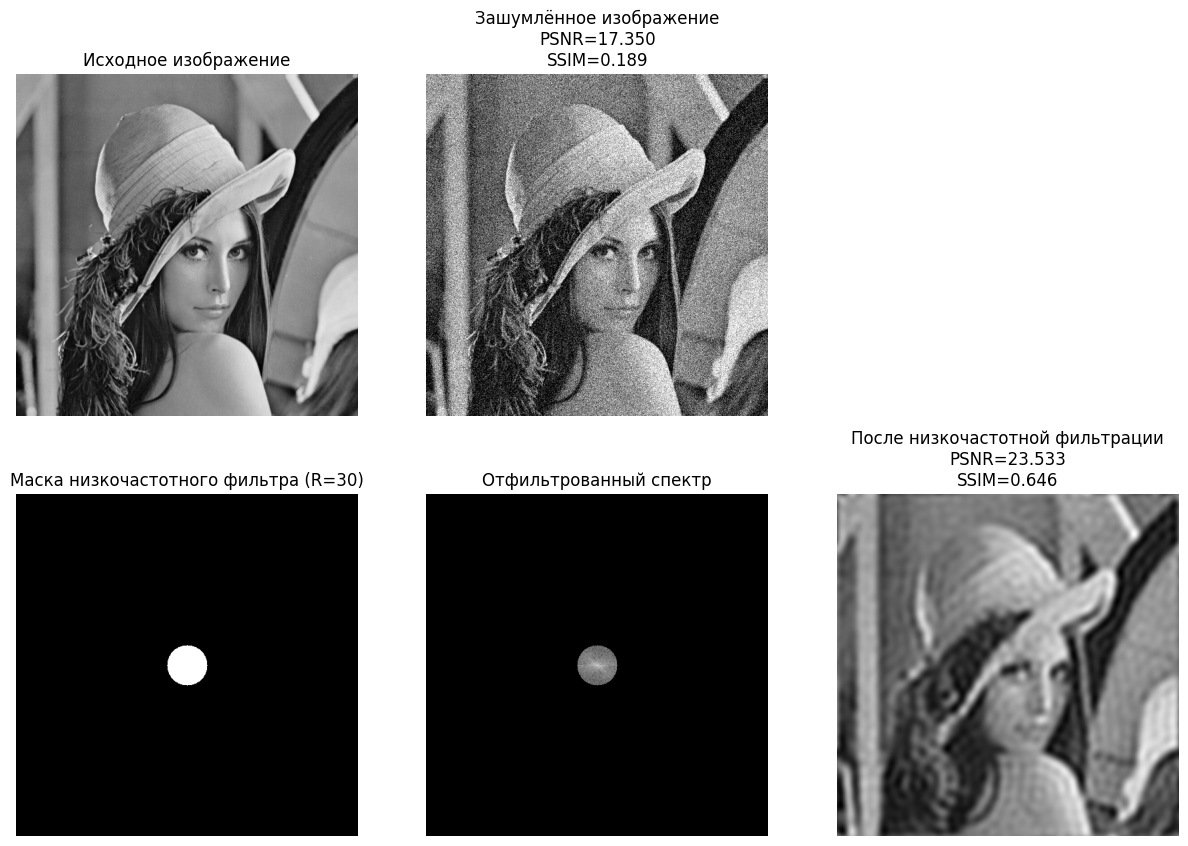

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

gray_image1 = cv.imread('./sample_data/lenna.png', cv.IMREAD_GRAYSCALE)
gray_image1 = cv.normalize(gray_image1.astype(np.float32), None, 0, 1, cv.NORM_MINMAX)

noisy_image = add_gauss_noise(gray_image1, 0, 0.02)

f = np.fft.fft2(noisy_image)
fshift = np.fft.fftshift(f)

rows, cols = noisy_image.shape
crow, ccol = rows // 2, cols // 2
radius = 30

mask = np.zeros((rows, cols), np.uint8)
cv.circle(mask, (ccol, crow), radius, 1, -1)

fshift_filtered = fshift * mask

f_ishift = np.fft.ifftshift(fshift_filtered)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)
img_back = cv.normalize(img_back, None, 0, 1, cv.NORM_MINMAX)

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.imshow(gray_image1, cmap='gray')
plt.title('Исходное изображение')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(noisy_image, cmap='gray')
plt.title(f'Зашумлённое изображение\nPSNR={getPSNR(gray_image1, noisy_image):.3f}\nSSIM={getSSIM(gray_image1, noisy_image)[0]:.3f}')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(mask, cmap='gray')
plt.title(f'Маска низкочастотного фильтра (R={radius})')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(np.log(1 + np.abs(fshift_filtered)), cmap='gray')
plt.title('Отфильтрованный спектр')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(img_back, cmap='gray')
plt.title(f'После низкочастотной фильтрации\nPSNR={getPSNR(gray_image1, img_back):.3f}\nSSIM={getSSIM(gray_image1, img_back)[0]:.3f}')
plt.axis('off')

plt.show()
